#Project Details

## Applying NLP for topic modelling in a real-life context

Applying NLP for topic modelling is crucial for data analysis in business because it enables companies to identify and understand key themes and patterns within large volumes of text data. This efficiency allows businesses to extract essential insights and trends without manually sifting through extensive documents. Automated topic modelling helps businesses make informed decisions faster, which helps to improve productivity and gain a competitive edge. Additionally, it supports better information management by uncovering underlying topics in reports, emails, customer feedback, and market research, which enhances overall business intelligence and strategic planning.


## **Business context**

The partner organisation has approximately 1 million members and 300 gyms across the world. As one of the world’s largest value fitness operators, the organisation appeals to a broad range of customers by offering high-quality, low-cost, and flexible fitness facilities. The company’s customer-centric proposition – affordable membership fees, no fixed-term contracts, and 24/7 access to high-quality gyms – differentiates it from more traditional gyms and elevates it as a market leader within this space.

This focus on the customer is centred on wanting to understand what motivates members to join and what factors influence their behaviours once they have joined. Understanding how to leverage innovative technology to influence, improve, and simplify their experience allows organisation to foster an open, welcoming, and diverse environment for its members while maintaining the value proposition that organisation is built upon.

With the shift in focus to value-for-money memberships across the gym industry, organisation seeks to achieve its mission of ‘inspiring a healthier world by providing members with affordable access to the benefits being healthy can offer’.


## **Objective**

By the end of this project, you will have analysed organisation's review data to uncover key drivers that provide actionable insights for enhancing customer experience.

In the Notebook, you will:

- Use two data sets containing customer reviews from Google and Trustpilot.
- Perform basic level analysis by finding the frequently used words in both data sets.
- Generate a wordcloud to visualise the most frequently used words in the reviews.
- Apply BERTopic for topic modelling, keeping track of gym locations, to identify common topics and words in the negative reviews.
- Identify the locations that have the most negative reviews.
- Use the built-in visualisation functions in BERTopic to cluster and visually represent the topics and words in these reviews, thereby helping to identify specific themes from the reviews.
- Conduct a comparison with Gensim’s LDA model to validate the topic modelling results.
- Perform emotion analysis to identify the emotions associated with customer reviews.
- Filter out angry reviews and apply BERTopic to discover prevalent topics and words being discussed these negative reviews.
- Leverage the multi-purpose capability of the state-of-the-art Falcon-7b-instruct model, with the help of prompts, to identify top topics in each review.
- Use a different prompt with the Falcon-7b-instruct model to further generate suggestions for improvements for the organisation, based on the top topics identified from the negative reviews.

# Import Packages and Data

In [1]:
!pip install gdown

In [2]:
import pandas as pd
import gdown
import os

#from google.colab import drive
#drive.mount('/content/drive')

# The original code concatenated a Google Drive folder URL with a filename,
# which pd.read_excel cannot interpret as a direct path to an Excel file.
# The project guidance specifies the data set's Drive link as:
# https://drive.google.com/drive/folders/1azch13dtGeAkbnEjqeoyl3nU9jheojU4
# Using this URL to download the files.
data_folder_url = "https://drive.google.com/drive/folders/1azch13dtGeAkbnEjqeoyl3nU9jheojU4"

# Create a directory to store the downloaded files.
# Using 'data_files' as the folder name.
download_dir = 'data_files'
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

# Download the contents of the Google Drive folder using gdown.
# This will download all files from the specified folder into the 'data_files' directory.
print(f"Downloading files from {data_folder_url} into '{download_dir}' directory...")
gdown.download_folder(url=data_folder_url, output=download_dir, quiet=True)
print("Download complete.")

# Now, read the Excel files from the local downloaded directory.
# Ensure the filenames match those in the folder.
# 'Google_12_months.xlsx' and 'Trustpilot_12_months.xlsx'
google_df = pd.read_excel(os.path.join(download_dir, 'Google_12_months.xlsx'))
trustpilot_df = pd.read_excel(os.path.join(download_dir, 'Trustpilot_12_months.xlsx'))

print(f"Google DataFrame shape: {google_df.shape}")
print(f"Trustpilot DataFrame shape: {trustpilot_df.shape}")

Download complete.
Google DataFrame shape: (23250, 7)
Trustpilot DataFrame shape: (16673, 15)


In [3]:
google_df.info()
trustpilot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23250 entries, 0 to 23249
Data columns (total 7 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   Customer Name                                  23250 non-null  object        
 1   SurveyID for external use (e.g. tech support)  23250 non-null  object        
 2   Club's Name                                    23250 non-null  object        
 3   Social Media Source                            23250 non-null  object        
 4   Creation Date                                  23250 non-null  datetime64[ns]
 5   Comment                                        13898 non-null  object        
 6   Overall Score                                  23250 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16673 entries, 0 to 16672


In [4]:
#fetch unique values for tags column in trustpilot_df
print(trustpilot_df['Tags'])

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
16668   NaN
16669   NaN
16670   NaN
16671   NaN
16672   NaN
Name: Tags, Length: 16673, dtype: float64


###
**Data Loading and Initial Exploration**

This section imports the customer review datasets from Google and Trustpilot, loads them into Pandas DataFrames, and performs an initial structural check. Basic inspection of column names, data types, and sample rows is carried out to confirm data integrity and ensure the datasets are ready for preprocessing and analysis.

# Conducting Initial Data Investigation

In [5]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=78164c7c7a6a9703700e1ca1b55ab9556bfa0289632f69e5e25300dabddfcc9b
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [6]:
#Use langdetect to detect language for comments column in both datasets
from langdetect import detect, DetectorFactory
import pandas as pd

# Make results reproducible
DetectorFactory.seed = 0

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False


In [7]:
#Add column is_english in both datasets and assign value as True if comments are in English language, else set False
google_df['is_english'] = google_df['Comment'].astype(str).apply(is_english)
trustpilot_df['is_english'] = trustpilot_df['Review Content'].astype(str).apply(is_english)

print(f"Google DataFrame shape: {google_df.shape}")
print(f"Trustpilot DataFrame shape: {trustpilot_df.shape}")

Google DataFrame shape: (23250, 8)
Trustpilot DataFrame shape: (16673, 16)


In [8]:
#drop column customer name in google_df as its not of importance
google_df = google_df.drop(columns=['Customer Name'])

#drop column Review Consumer User ID, Tags - Consumer ID is of not importance and Tags column is null for all rows
trustpilot_df = trustpilot_df.drop(columns=['Review Consumer User ID', 'Tags'])

#remove rows with missing values in comment column for google_df
google_df = google_df.dropna(subset=['Comment'])

#remove rows with missing values in review content column for trustpilot_df
trustpilot_df = trustpilot_df.dropna(subset=['Review Content'])

#remove rows with lanuage not English for google_df
google_df = google_df[google_df['is_english']]

#remove rows with language not English for trustpilot_df
trustpilot_df = trustpilot_df[trustpilot_df['is_english']]

print(f"Google DataFrame shape: {google_df.shape}")
print(f"Trustpilot DataFrame shape: {trustpilot_df.shape}")

Google DataFrame shape: (11878, 7)
Trustpilot DataFrame shape: (15813, 14)


In [9]:
#find number of unique locations in google_df
print(f"Number of unique locations in Google data set:", google_df['Club\'s Name'].nunique())

#find number of unique locations in trustpilot_df
print(f"Number of unique locations in Trustpilot data set: ", trustpilot_df['Location Name'].nunique())

#number of common locations between google_df and trustpilot_df
print(f"Number of common locations between Google and Trustpilot data sets: ", len(set(google_df['Club\'s Name']).intersection(set(trustpilot_df['Location Name']))))

Number of unique locations in Google data set: 455
Number of unique locations in Trustpilot data set:  376
Number of common locations between Google and Trustpilot data sets:  310


In [12]:
import nltk
import re
import spacy
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load spaCy model once (IMPORTANT for performance)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if isinstance(text, str): # Ensure the input is a string
        # 1. Lowercase
        text = text.lower()

        # 2. Remove punctuation & numbers
        text = re.sub(r'[^A-Za-zÀ-ÖØ-öø-ÿ\s]', '', text) # Remove punctuation & numbers
        text = text.translate(str.maketrans('', '', string.punctuation))

        # 3. Remove stopwords
        text = ' '.join([word for word in text.split() if word not in stop_words])

    return str(text) # Convert non-string types to string (e.g., if there were NaNs, though we dropped them)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
google_df['Comment'] = google_df['Comment'].apply(preprocess_text) # Apply the function element-wise
trustpilot_df['Review Content'] = trustpilot_df['Review Content'].apply(preprocess_text) # Apply the function element-wise

#check comment column of google_df and trustpilot_df
print("Google DataFrame Comment head:")
print(google_df['Comment'].head())
print("\nTrustpilot DataFrame Review Content head:")
print(trustpilot_df['Review Content'].head())

Google DataFrame Comment head:
1    many students two local colleges go leave rubb...
2    best range equipment cheaper regular gyms prof...
3    good gym busy tend get busy late afternoon har...
4    current member gym quite dirty often theres so...
7    gym way hot even workout windows open ac barel...
Name: Comment, dtype: object

Trustpilot DataFrame Review Content head:
1    love part gym superb value money time day love...
2                             extremely busy fresh air
3                            great vibes fantastic gym
4                      clean well managed classes good
5    good budget gym open young keen friendly staff...
Name: Review Content, dtype: object


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


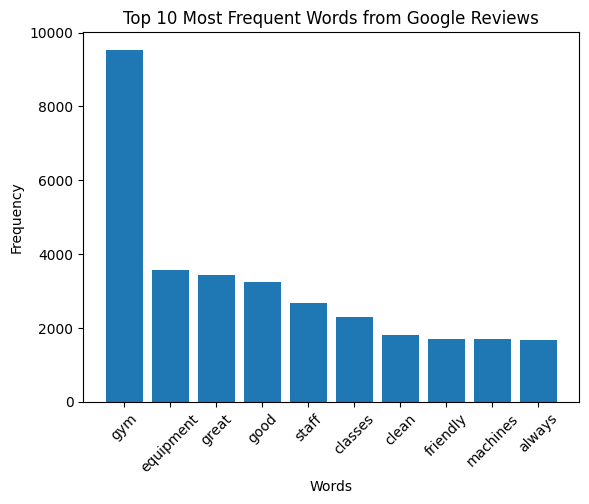

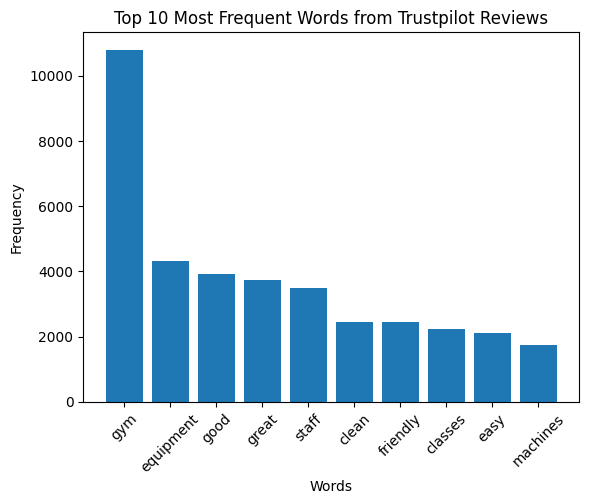

In [31]:
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

nltk.download('punkt_tab')

def analyze_text_data(text_series):
    """
    Tokenizes text, calculates frequency distribution, and extracts top 10 words and counts.
    Args:
        text_series (pd.Series): A pandas Series containing text data.
    Returns:
        tuple: (tokens, freq_dist, top_10, words, counts)
    """
    tokens = word_tokenize(' '.join(text_series))
    freq_dist = FreqDist(tokens)
    top_10 = freq_dist.most_common(10)
    words, counts = zip(*top_10)
    return tokens, freq_dist, top_10, words, counts

def plot_top_words_histogram(words, counts, title):
    """
    Plots a histogram/bar plot showing the top words.
    Args:
        words (list): List of words to plot.
        counts (list): List of counts corresponding to the words.
        title (str): Title of the plot.
    """
    plt.figure()
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.show()

# Analyze Google reviews
google_tokens, google_freq_dist, google_top_10, google_words, google_counts = analyze_text_data(google_df['Comment'])

# Analyze Trustpilot reviews
trustpilot_tokens, trustpilot_freq_dist, trustpilot_top_10, trustpilot_words, trustpilot_counts = analyze_text_data(trustpilot_df['Review Content'])

# Plot histogram for Google reviews
plot_top_words_histogram(google_words, google_counts, "Top 10 Most Frequent Words from Google Reviews")

# Plot histogram for Trustpilot reviews
plot_top_words_histogram(trustpilot_words, trustpilot_counts, "Top 10 Most Frequent Words from Trustpilot Reviews")

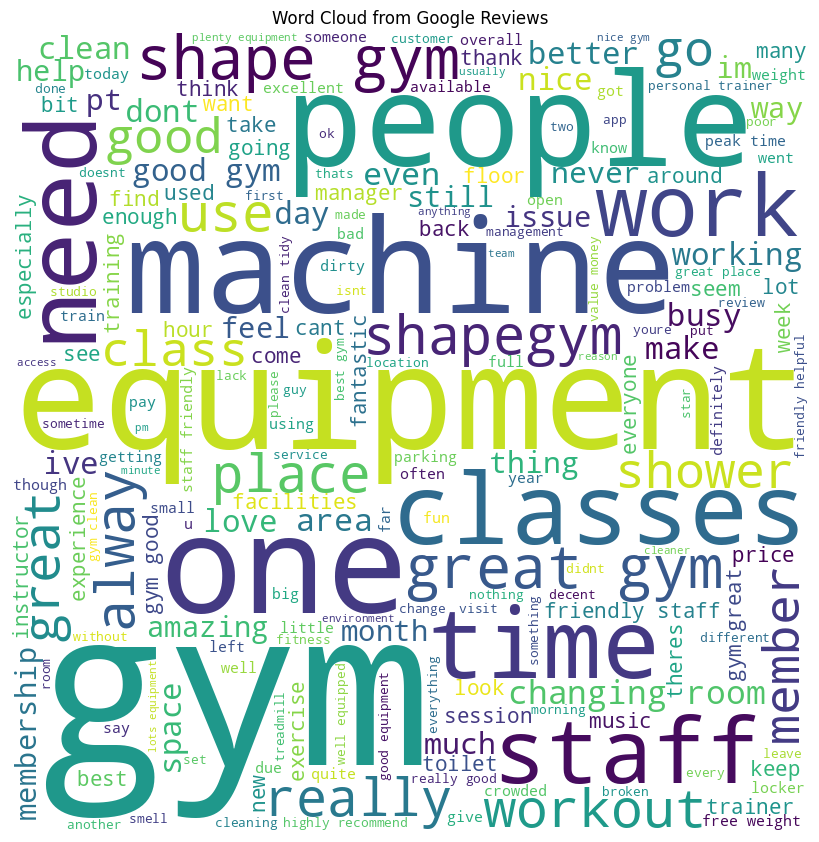

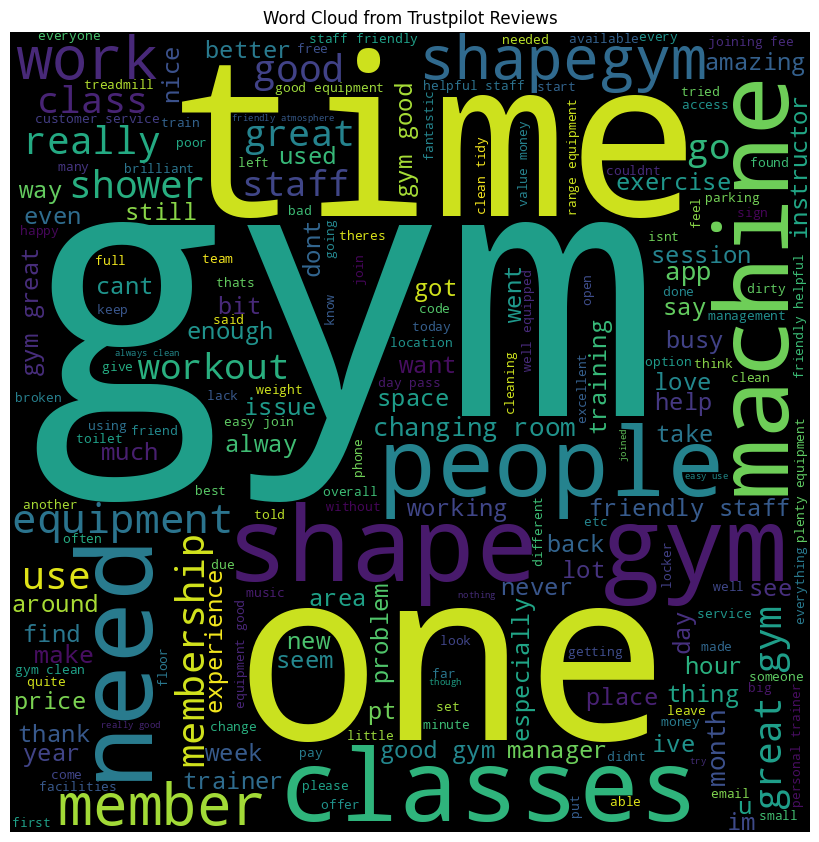

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(tokens, title, background_color='white'):
    """
    Generates and plots a word cloud from a list of tokens.
    Args:
        tokens (list): A list of words (tokens).
        title (str): The title for the word cloud plot.
        background_color (str): The background color of the word cloud.
    """
    wordcloud = WordCloud(width=800, height=800, background_color=background_color).generate(' '.join(tokens))
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(title)
    plt.show()

# Generate word cloud for Google reviews
plot_word_cloud(google_tokens, "Word Cloud from Google Reviews", background_color='white')

# Generate word cloud for Trustpilot reviews
plot_word_cloud(trustpilot_tokens, "Word Cloud from Trustpilot Reviews", background_color='black')

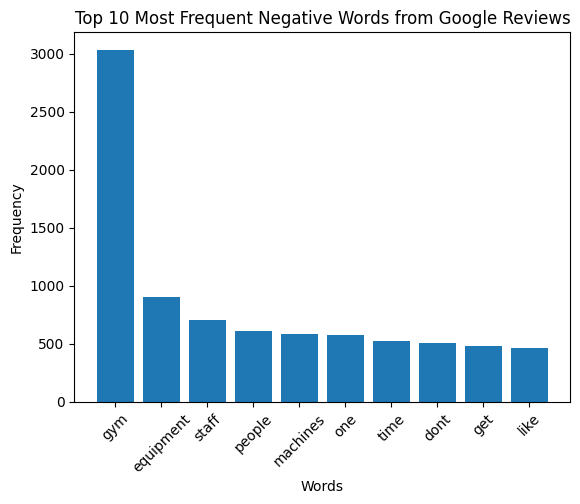

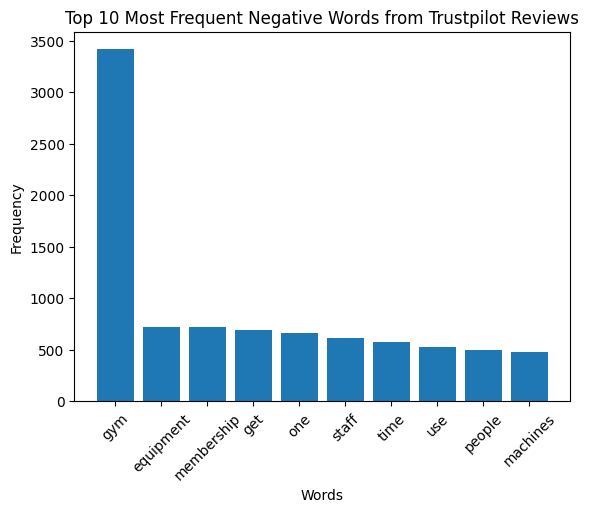

In [33]:
#filter reviews google_df where overall scores < 3
google_negative_df = google_df[google_df['Overall Score'] < 3]

#filter reviews trustpilot_df where stars < 3
trustpilot_negative_df = trustpilot_df[trustpilot_df['Review Stars'] < 3]

# Analyze Google reviews
google_negative_tokens, google_negative_freq_dist, google_negative_top_10, google_negative_words, google_negative_counts = analyze_text_data(google_negative_df['Comment'])

# Analyze Trustpilot reviews
trustpilot_negative_tokens, trustpilot_negative_freq_dist, trustpilot_negative_top_10, trustpilot_negative_words, trustpilot_negative_counts = analyze_text_data(trustpilot_negative_df['Review Content'])

# Plot histogram for Google negative reviews
plot_top_words_histogram(google_negative_words, google_negative_counts, "Top 10 Most Frequent Negative Words from Google Reviews")

# Plot histogram for Trustpilot negative reviews
plot_top_words_histogram(trustpilot_negative_words, trustpilot_negative_counts, "Top 10 Most Frequent Negative Words from Trustpilot Reviews")

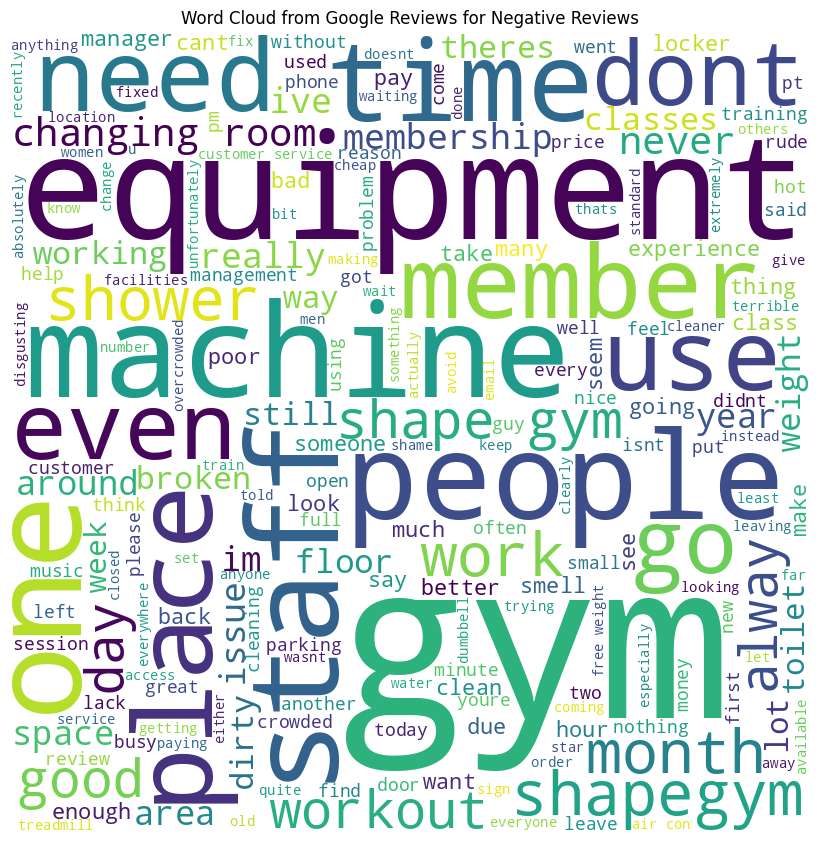

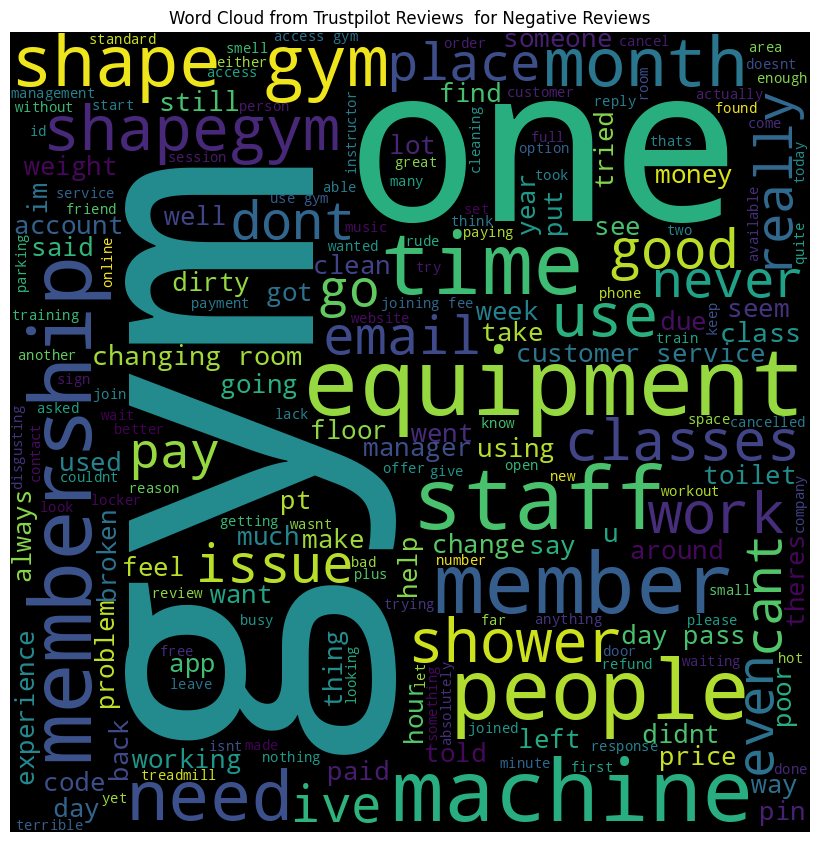

In [34]:
# Generate word cloud for Google negative reviews
plot_word_cloud(google_negative_tokens, "Word Cloud from Google Reviews for Negative Reviews", background_color='white')

# Generate word cloud for Trustpilot negative reviews
plot_word_cloud(trustpilot_negative_tokens, "Word Cloud from Trustpilot Reviews  for Negative Reviews", background_color='black')

###
**Initial Data Cleaning and Exploratory Analysis**

In this section, the review datasets are cleaned to remove noise, including empty entries and non-English reviews, ensuring consistency and relevance. The text is then preprocessed by removing punctuation, stop words, and applying lemmatisation. This refined data is explored to identify the most frequently occurring terms, with a particular focus on commonly used negative words, providing an initial view of sentiment patterns prior to advanced modelling.

# Conducting Initial Topic Modelling

In [35]:
from pprint import pprint

#filter out reviews that have common locations in googles_negative_df and trustpilot_negative_df
google_common_location_negative_df = google_negative_df[~google_negative_df['Club\'s Name'].isin(trustpilot_negative_df['Location Name'])]
trustpilot_common_location_negative_df = trustpilot_negative_df[~trustpilot_negative_df['Location Name'].isin(google_negative_df['Club\'s Name'])]

#merge both and form a new list
negative_reviews = google_common_location_negative_df['Comment'].tolist() + trustpilot_common_location_negative_df['Review Content'].tolist()

pprint(negative_reviews)

['extremely disappointed level hygiene gym mention rude unhelpful staff '
 'returning',
 'go kirkby times morning stopped going due fact theres gang eastern europeans '
 'hanging around weight benches nothing even working others watched poor guy '
 'ignored asked could use weight bench sit using phones funny theres going '
 'riot underhanded things phones rumours going around',
 'could rate zero stars would worst shapegym branch ive disgustingly dirty '
 'everywhere matts falling pieces equipment never gets cleaned smell '
 'unbearable one thing old equipment another thing feel scared touch machines '
 'ive never seen cleaner gym really shows',
 'gym ok could please lower music volume everyone shares musical tastes wed '
 'like enjoy music without loud background noise',
 'good',
 'bit disappointed lack equipment gym',
 'terrible gym dont recommend anyone joining member gym black water maldon cm '
 'happy service im paying member ive lost pin app always logging pin also '
 'always keep

In [36]:
# Install BERTopic library
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.7 MB/s eta 0:00:00


In [37]:
#user BERTTopic on cleaned data set
from tqdm import tqdm
from bertopic import BERTopic

topic_model_negative_reviews = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics_negative_reviews, probs_negative_reviews = topic_model_negative_reviews.fit_transform(negative_reviews)

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
2026-01-26 12:51:41,688 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/64 [00:00<?, ?it/s]

2026-01-26 12:51:47,873 - BERTopic - Embedding - Completed ✓
2026-01-26 12:51:47,875 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-26 12:52:06,773 - BERTopic - Dimensionality - Completed ✓
2026-01-26 12:52:06,774 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-26 12:52:06,974 - BERTopic - Cluster - Completed ✓
2026-01-26 12:52:06,978 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-26 12:52:07,055 - BERTopic - Representation - Completed ✓


In [38]:
#list out top topics along with their document frequencies
topic_model_negative_reviews.get_topic_info()

Topic  Count                                        Name  \
0      -1    740             -1_gym_get_membership_equipment   
1       0    172                         0_pass_day_pin_code   
2       1    126                 1_fee_joining_discount_code   
3       2    108                 2_membership_gym_access_fee   
4       3     86            3_equipment_gym_machines_weights   
5       4     68              4_machines_busy_enough_crowded   
6       5     53                   5_staff_rude_manager_like   
7       6     51             6_customer_shapegym_service_gym   
8       7     51                 7_classes_class_book_booked   
9       8     49                          8_pin_log_sent_app   
10      9     43           9_customer_service_worst_terrible   
11     10     41                 10_air_hot_conditioning_con   
12     11     40            11_toilets_dirty_toilet_changing   
13     12     36            12_upgrade_email_account_address   
14     13     32             13_cleaning_clean_wipe_machines   
15     14     29                 14_toilets_smelly_smell_gym   
16     15     29                    15_open_pm_opening_hours   
17     16     25                 16_app_download_load_family   
18     17     24                   17_parking_car_park_fines   
19     18     23                18_water_cold_showers_shower   
20     19     23                19_machine_weights_press_leg   
21     20     23                  20_cancel_direct_debit_app   
22     21     20               21_payment_account_bank_money   
23     22     20    22_cancel_button_cancellation_membership   
24     23     17                  23_shower_showers_cold_gym   
25     24     16            24_music_loud_classes_headphones   
26     25     16              25_lockers_locker_stuff_stolen   
27     26     14                  26_buddy_link_account_work   
28     27     13         27_induction_book_booked_inductions   
29     28     11  28_cancelled_company_accounts_confirmation   
30     29     11              29_wifi_palmers_internet_green   
31     30     11               30_shapegym_matter_opened_mum   
32     31     10         31_machines_handles_rarely_replaced   
33     32     10                     32_join_tried_guest_via   

                                       Representation  \
0   [gym, get, membership, equipment, people, one,...   
1   [pass, day, pin, code, gym, bought, didnt, get...   
2   [fee, joining, discount, code, charged, promo,...   
3   [membership, gym, access, fee, joining, paid, ...   
4   [equipment, gym, machines, weights, one, peopl...   
5   [machines, busy, enough, crowded, equipment, p...   
6   [staff, rude, manager, like, feel, management,...   
7   [customer, shapegym, service, gym, money, memb...   
8   [classes, class, book, booked, instructor, pil...   
9   [pin, log, sent, app, received, email, send, w...   
10  [customer, service, worst, terrible, everythin...   
11  [air, hot, conditioning, con, summer, ac, turn...   
12  [toilets, dirty, toilet, changing, room, sink,...   
13  [upgrade, email, account, address, friend, mem...   
14  [cleaning, clean, wipe, machines, dirty, equip...   
15  [toilets, smelly, smell, gym, changing, toilet...   
16  [open, pm, opening, hours, closed, time, gym, ...   
17  [app, download, load, family, wont, phone, doe...   
18  [parking, car, park, fines, hes, fine, gym, fi...   
19  [water, cold, showers, shower, warm, hot, ever...   
20  [machine, weights, press, leg, legs, machines,...   
21  [cancel, direct, debit, app, company, cancella...   
22  [payment, account, bank, money, cards, double,...   
23  [cancel, button, cancellation, membership, pag...   
24  [shower, showers, cold, gym, temperature, faci...   
25  [music, loud, classes, headphones, shouting, s...   
26  [lockers, locker, stuff, stolen, stole, room, ...   
27  [buddy, link, account, work, wont, use, bring,...   
28  [induction, book, booked, inductions, website,...   
29  [cancelled, company, accounts, confirmation, r...

In [39]:
#for top 2 topics list out the top words
topic_model_negative_reviews.get_topic(0)
topic_model_negative_reviews.get_topic(1)

[('fee', np.float64(0.10904332062833805)),
 ('joining', np.float64(0.10902438129802729)),
 ('discount', np.float64(0.07235115428032816)),
 ('code', np.float64(0.07186415286681908)),
 ('charged', np.float64(0.035301628313171386)),
 ('promo', np.float64(0.03259870931279302)),
 ('applied', np.float64(0.032164376917687865)),
 ('month', np.float64(0.030418389565401514)),
 ('price', np.float64(0.027352608256915035)),
 ('paid', np.float64(0.02528460356725861))]

In [40]:
#show interactive visualisation to topics to identify cluster of topics and to understand intertopic distance map
topic_model_negative_reviews.visualize_topics()


In [41]:
#barchart of topics displaying top 5 words in each topic
topic_model_negative_reviews.visualize_barchart()

In [42]:
#plot heatmap showcasing similiarity matrix for 10 clusters
topic_model_negative_reviews.visualize_heatmap()

In [43]:
topic_freq = topic_model_negative_reviews.get_topic_freq()

top_10_topics = (
    topic_freq[topic_freq.Topic != -1]  # exclude outliers
    .head(10)['Topic']
    .tolist()
)

In [44]:
topic_model_negative_reviews.visualize_heatmap(topics=top_10_topics)

## Insights (Cluster-wise Topic Descriptions & Themes for reviews from common location in both Google and Trustpilot)
**Cluster 0** – Membership & Access Issues
* **Top words:** membership, gym, access, email, join
* **Description:** Reviews discussing membership activation, joining procedures, access problems, and email communication.
* **General theme:** Membership onboarding & account access

**Cluster 1** – Gym Equipment & Facilities
* **Top words:** equipment, gym, machines, weights, people
* **Description:** Focuses on availability, quality, and condition of gym equipment and shared spaces.
* **General theme:** Physical infrastructure & equipment quality

**Cluster 2** – Passcodes & Entry Systems
* Top words: pass, day, pin, code, gym
* Description: Concerns around digital access systems such as PINs, entry codes, and daily passes.
* General theme: Digital access & authentication issues

**Cluster 3** – Pricing, Fees & Promotions
* **Top words:** joining, fee, discount, code, promo
* **Description:** Reviews highlighting pricing structures, joining fees, discounts, and promotional codes.
* **General theme:** Pricing transparency & promotional offers

**Cluster 4** – Overcrowding & Capacity
* **Top words:** machines, busy, crowded, equipment, enough
* **Description:** Complaints about overcrowding, lack of available machines, and peak-time co*ngestion.
* **General theme:** Capacity management & crowding

**Cluster 5** – Customer Service & Brand Experience
* **Top words:** customer, service, membership, member
* **Description:** Feedback related to brand-level customer support, service quality, and member handling.
* **General theme:** Customer service & organizational responsiveness

**Cluster 6** – Staff Behaviour & Management
* **Top words:** staff, rude, experience, like, manager
* **Description:** Reviews describing interactions with staff, including professionalism and management conduct.
* **General theme:** Staff behaviour & service professionalism

**Cluster 7** – Class Booking & Instructors
* **Top words:** classes, class, book, booked, instructor
* **Description:** Issues and experiences related to class scheduling, booking systems, and instructors.
* **General theme:** Group classes & scheduling systems

**Cluster 8** – Billing & Payment Issues (inferred cluster)
* **Top words:** payment, charged, refund, billed, money
* **Description:** Complaints about incorrect charges, refunds, or payment processing delays.
* **General theme:** Financial transactions & billing accuracy

**Cluster 9** – App & Technical Experience (inferred cluster)
* **Top words:** app, login, error, update, system
* **Description:** Technical issues related to mobile apps, logins, and system reliability.
* **General theme:** Digital platform usability & reliability

# Performing Further Data Investigation

In [45]:
#List out top 20 locations with highest number of negative reviews from google reviews
google_top_20_negative_review_locations = google_df[google_df['Overall Score'] < 3].groupby('Club\'s Name').size().sort_values(ascending=False).head(20)
trustpilot_top_20_negative_review_locations = trustpilot_df[trustpilot_df['Review Stars'] < 3].groupby('Location Name').size().sort_values(ascending=False).head(20)

print("Top 20 Locations with Highest Number of Negative Reviews from Google Reviews:")
print(google_top_20_negative_review_locations)

print("\nTop 20 Locations with Highest Number of Negative Reviews from Trustpilot Reviews:")
print(trustpilot_top_20_negative_review_locations)

Top 20 Locations with Highest Number of Negative Reviews from Google Reviews:
Club's Name
London Stratford            59
London Woolwich             26
London Canary Wharf         26
London Enfield              24
London Palmers Green        22
London Swiss Cottage        22
London Leytonstone          21
Birmingham City Centre      20
Bradford Thornbury          19
Peterborough Serpentine     18
New Barnet                  18
Wakefield                   18
London Hoxton               18
Walsall Crown Wharf         17
Manchester Exchange Quay    17
London Hayes                17
London Seven Sisters        17
Nottingham Colwick          16
London Piccadilly           15
London Muswell Hill         15
dtype: int64

Top 20 Locations with Highest Number of Negative Reviews from Trustpilot Reviews:
Location Name
Leicester Walnut Street      48
345                          43
London Enfield               23
London Stratford             22
Burnham                      19
London Bermondsey   

In [46]:
#common locations between google_top_20_negative_review_locations and trustpilot_top_20_negative_review_locations
common_locations = set(google_top_20_negative_review_locations.index).intersection(set(trustpilot_top_20_negative_review_locations.index))
print("Common Locations between Google and Trustpilot:")
print(common_locations)

Common Locations between Google and Trustpilot:
{'New Barnet', 'London Seven Sisters', 'London Stratford', 'London Enfield', 'Bradford Thornbury', 'London Hayes', 'London Swiss Cottage', 'Birmingham City Centre'}


In [47]:
google_df = google_df.rename(columns={
    "Club's Name": "Location Name"
})

for df in [google_df, trustpilot_df]:
    df['Location Name'] = (
        df['Location Name']
        .astype(str)
        .str.strip()
        .str.lower()
    )

google_df['source'] = 'Google'
trustpilot_df['source'] = 'Trustpilot'

#concatenate instead of merge row-by-row, since both have different reviews and we don't want to lose data.
df_both_reviews = pd.concat([google_df, trustpilot_df], ignore_index=True)


In [48]:

#fetch rows where location name is nan
df_both_reviews[df_both_reviews['Location Name']== 'nan']
trustpilot_df[trustpilot_df['Location Name']== 'nan'].count()

Review ID                   4920
Review Created (UTC)        4920
Review Title                4920
Review Content              4920
Review Stars                4920
Source Of Review            4920
Review Language             4920
Domain URL                  4920
Webshop Name                4920
Business Unit ID            4920
Company Reply Date (UTC)    4741
Location Name               4920
Location ID                    0
is_english                  4920
source                      4920
dtype: int64

In [49]:
location_wise_review_count = df_both_reviews.groupby(['Location Name', 'source']).size().unstack(fill_value=0).reset_index()
location_wise_review_count = location_wise_review_count.rename(columns={'Google':'google_reviews','Trustpilot': 'trustpilot_reviews'})
location_wise_review_count['Total Reviews'] = location_wise_review_count['google_reviews'] + location_wise_review_count['trustpilot_reviews']
location_wise_review_count = location_wise_review_count.sort_values(by='Total Reviews', ascending=False)
location_wise_review_count.head(10)

source             Location Name  google_reviews  trustpilot_reviews  \
382                          nan               0                4920   
209                     elkridge             183                   0   
454                  springfield             181                   0   
336            london park royal              47                 134   
372     manchester market street             125                  29   
62                           345               0                 153   
344             london stratford              93                  56   
310              london finchley              91                  50   
270      leicester walnut street              55                  79   
262                leeds bramley              98                  28   

source  Total Reviews  
382              4920  
209               183  
454               181  
336               181  
372               154  
62                153  
344               149  
310               141  
270               134  
262               126

In [50]:
#fetch top 30 locations from location_wise_review_count and filter google_df and trustpilot_df for those locations
top_30_locations = location_wise_review_count.head(30)['Location Name'].tolist()
google_df_top_30 = google_df[google_df['Location Name'].isin(top_30_locations)]
trustpilot_df_top_30 = trustpilot_df[trustpilot_df['Location Name'].isin(top_30_locations)]

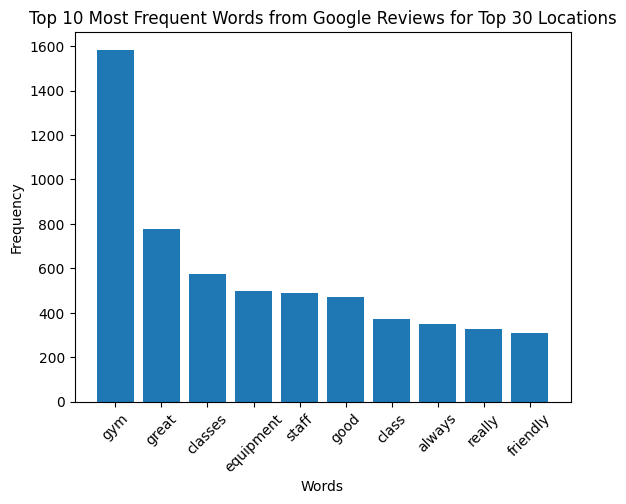

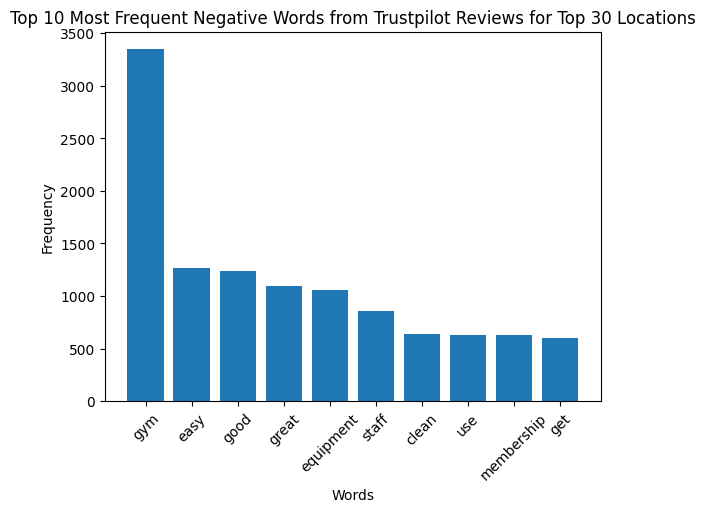

In [51]:
# Analyze Google reviews
google_top_30_tokens, google_top_30_freq_dist, google_top_30_top_10, google_top_30_words, google_top_30_counts = analyze_text_data(google_df_top_30['Comment'])

# Analyze Trustpilot reviews
trustpilot_top_30_tokens, trustpilot_top_30_freq_dist, trustpilot_top_30_top_10, trustpilot_top_30_words, trustpilot_top_30_counts = analyze_text_data(trustpilot_df_top_30['Review Content'])

# Plot histogram for Google reviews
plot_top_words_histogram(google_top_30_words, google_top_30_counts, "Top 10 Most Frequent Words from Google Reviews for Top 30 Locations")

# Plot histogram for Trustpilot reviews
plot_top_words_histogram(trustpilot_top_30_words, trustpilot_top_30_counts, "Top 10 Most Frequent Negative Words from Trustpilot Reviews for Top 30 Locations")

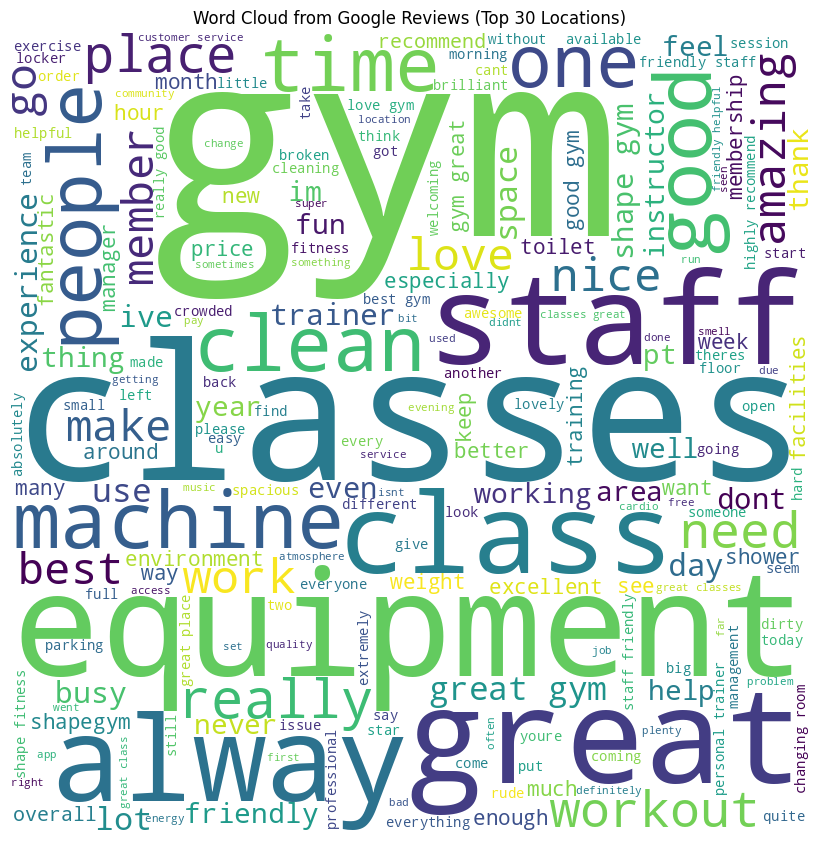

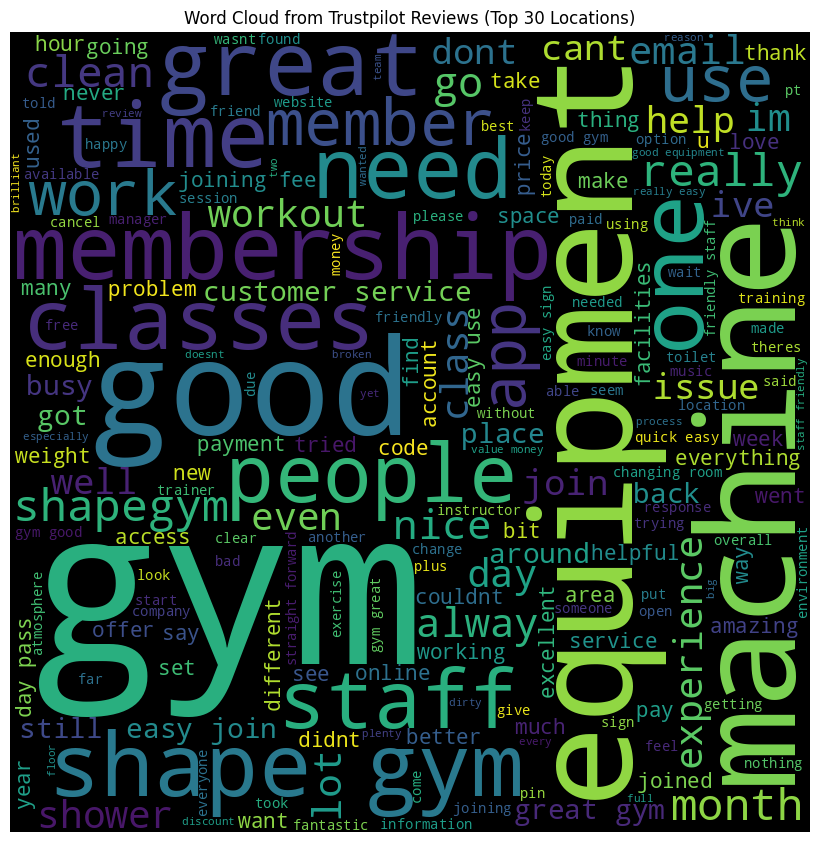

In [52]:
# Generate word cloud for Google reviews
plot_word_cloud(google_top_30_tokens, "Word Cloud from Google Reviews (Top 30 Locations)", background_color='white')

# Generate word cloud for Trustpilot reviews
plot_word_cloud(trustpilot_top_30_tokens, "Word Cloud from Trustpilot Reviews (Top 30 Locations)", background_color='black')

## Highlight the difference in results based on bar chart and word cloud

**Comparison of High-Volume Review Locations**

This section compares the top 30 locations with the highest volume of reviews across Google and Trustpilot, focusing on locations common to both datasets. Visualisations using bar charts and word clouds reveal that the dominant themes and frequently mentioned words remain largely consistent across platforms. Differences are primarily observed in the ordering and relative frequency of terms rather than in the emergence of new topics, indicating alignment in customer feedback patterns across review sources.

In [53]:
#combine reviews from google_df_top_30 and trustpilot_df_top_30 and run through Bertopic
combined_reviews = google_df_top_30['Comment'].tolist() + trustpilot_df_top_30['Review Content'].tolist()
topic_model_top_30 = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics_top_30, probs_top_30 = topic_model_top_30.fit_transform(combined_reviews)

2026-01-26 12:54:17,980 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/265 [00:00<?, ?it/s]

2026-01-26 12:54:22,107 - BERTopic - Embedding - Completed ✓
2026-01-26 12:54:22,108 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-26 12:54:53,414 - BERTopic - Dimensionality - Completed ✓
2026-01-26 12:54:53,415 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-26 12:55:01,684 - BERTopic - Cluster - Completed ✓
2026-01-26 12:55:01,690 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-26 12:55:01,874 - BERTopic - Representation - Completed ✓


In [54]:
#list out top topics along with their document frequencies
topic_model_top_30.get_topic_info()

Topic  Count                                        Name  \
0       -1   3402                 -1_gym_great_classes_always   
1        0    215              0_machines_weights_machine_leg   
2        1    164                 1_fee_joining_code_discount   
3        2    142               2_cancel_payment_debit_direct   
4        3    110               3_membership_paid_access_plus   
..     ...    ...                                         ...   
147    146     11                        146_log_pin_app_wont   
148    147     11         147_complete_delt_resolution_fitter   
149    148     11            148_professional_organised_cg_cj   
150    149     10                149_smooth_took_process_load   
151    150     10  150_broken_components_exception_rearranged   

                                        Representation  \
0    [gym, great, classes, always, equipment, good,...   
1    [machines, weights, machine, leg, press, broke...   
2    [fee, joining, code, discount, promo, charged,...   
3    [cancel, payment, debit, direct, bank, members...   
4    [membership, paid, access, plus, pay, gyms, pe...   
..                                                 ...   
147  [log, pin, app, wont, tym, send, suck, reg, em...   
148  [complete, delt, resolution, fitter, complicat...   
149  [professional, organised, cg, cj, ct, dr, kkkk...   
150  [smooth, took, process, load, min, mins, simpl...   
151  [broken, components, exception, rearranged, pr...   

                                   Representative_Docs  
0    [going gym ish months definitely one best gyms...  
1    [weights scattered everywhere spend half time ...  
2    [input joining fee promo code charged joining ...  
3    [ive trying cancel membership almost impossibl...  
4    [join gym th march cheap something could work ...  
..                                                 ...  
147  [cant log app, easy set membership received em...  
148      [easy complete, easy complete, easy complete]  
149         [professional, professional, professional]  
150         [smooth easy, smooth easy, smooth process]  
151  [certain machines dont work properly missing k...  

[152 rows x 5 columns]

In [55]:
#plot heatmap showcasing similiarity matrix for 10 clusters
topic_model_top_30.visualize_heatmap()

In [56]:
topic_model_top_30_freq = topic_model_top_30.get_topic_freq()

top_10_topics_30_locations = (
    topic_model_top_30_freq[topic_model_top_30_freq.Topic != -1]  # exclude outliers
    .head(10)['Topic']
    .tolist()
)

In [57]:
topic_model_top_30.visualize_heatmap(topics=top_10_topics_30_locations)

##
**Comparison with Initial BERTopic Run**

The results from this BERTopic run differ notably from the initial analysis. The topic similarity matrix shows a clear shift, and comparison of the top 10 words indicates only ~30% overlap for Google reviews and ~60% overlap for Trustpilot reviews, suggesting a meaningful change in dominant themes.

This shift is primarily driven by the focus on the top 30 locations with the highest volume of negative reviews, which surface more concrete and recurring customer issues. As a result, the topics in this run reflect stronger negative sentiment and more operationally specific concerns, rather than broader or more general feedback observed earlier.

An additional insight from this run is the increased prominence of customer service–related problems, which emerge more consistently across topics. This indicates that customer service is a key driver of dissatisfaction at high-volume negative locations and represents a more actionable area for targeted improvement compared to the first run.



# Conducting Emotion Analysis

In [ ]:
!pip install transformers torch

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name='bhadresh-savani/bert-base-uncased-emotion'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
text= [
    "I waited for hours, very bad experience",
    "Not good, not bad, just average",
    "Amazing staff and great atmosphere"
]

inputs = tokenizer(
    text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length = 128
)

# Move input tensors to the same device as the model
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
  outputs = model(**inputs)

predictions = torch.argmax(outputs.logits, dim=1)

predicted_class_labels = [model.config.id2label[p.item()] for p in predictions]

print(predicted_class_labels)

['anger', 'joy', 'joy']


In [ ]:
import pandas as pd
from torch.utils.data import DataLoader

def predict_batch_emotion(texts, batch_size=4):
  labels=[]
  for i in range(0, len(texts), batch_size):
    print(f"Processing batch {i} to {i+batch_size}")
    batch_texts = texts[i:i+batch_size]
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)

    # Move input tensors to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
      outputs = model(**inputs)

    predictions = torch.argmax(outputs.logits, dim=1)
    labels.extend([model.config.id2label[p.item()] for p in predictions])
  return labels

In [ ]:
texts_google_comment = google_df['Comment'].fillna("").astype(str).tolist()
google_df['emotion'] = predict_batch_emotion(texts_google_comment, batch_size=8)

Processing batch 0 to 8
Processing batch 8 to 16
Processing batch 16 to 24
Processing batch 24 to 32
Processing batch 32 to 40
Processing batch 40 to 48
Processing batch 48 to 56
Processing batch 56 to 64
Processing batch 64 to 72
Processing batch 72 to 80
Processing batch 80 to 88
Processing batch 88 to 96
Processing batch 96 to 104
Processing batch 104 to 112
Processing batch 112 to 120
Processing batch 120 to 128
Processing batch 128 to 136
Processing batch 136 to 144
Processing batch 144 to 152
Processing batch 152 to 160
Processing batch 160 to 168
Processing batch 168 to 176
Processing batch 176 to 184
Processing batch 184 to 192
Processing batch 192 to 200
Processing batch 200 to 208
Processing batch 208 to 216
Processing batch 216 to 224
Processing batch 224 to 232
Processing batch 232 to 240
Processing batch 240 to 248
Processing batch 248 to 256
Processing batch 256 to 264
Processing batch 264 to 272
Processing batch 272 to 280
Processing batch 280 to 288
Processing batch 288

In [ ]:
texts_trustpilot_comment = trustpilot_df['Review Content'].fillna("").astype(str).tolist()
trustpilot_df['emotion'] = predict_batch_emotion(texts_trustpilot_comment, batch_size=8)

Processing batch 0 to 8
Processing batch 8 to 16
Processing batch 16 to 24
Processing batch 24 to 32
Processing batch 32 to 40
Processing batch 40 to 48
Processing batch 48 to 56
Processing batch 56 to 64
Processing batch 64 to 72
Processing batch 72 to 80
Processing batch 80 to 88
Processing batch 88 to 96
Processing batch 96 to 104
Processing batch 104 to 112
Processing batch 112 to 120
Processing batch 120 to 128
Processing batch 128 to 136
Processing batch 136 to 144
Processing batch 144 to 152
Processing batch 152 to 160
Processing batch 160 to 168
Processing batch 168 to 176
Processing batch 176 to 184
Processing batch 184 to 192
Processing batch 192 to 200
Processing batch 200 to 208
Processing batch 208 to 216
Processing batch 216 to 224
Processing batch 224 to 232
Processing batch 232 to 240
Processing batch 240 to 248
Processing batch 248 to 256
Processing batch 256 to 264
Processing batch 264 to 272
Processing batch 272 to 280
Processing batch 280 to 288
Processing batch 288

<Axes: xlabel='emotion'>

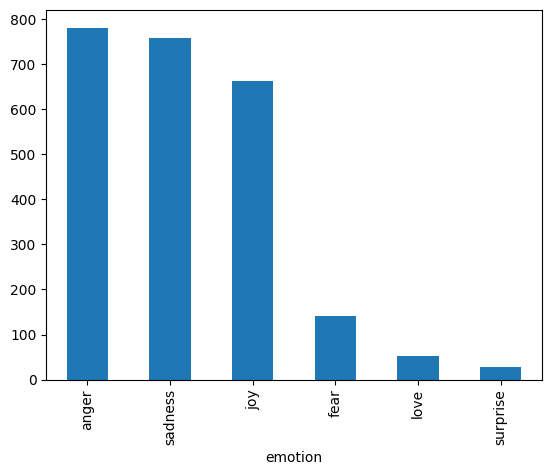

In [ ]:
#plot bar plot to show top emotion distribution for all negative reviews in google_df
google_negative_df = google_df[google_df['Overall Score'] < 3]
google_negative_df['emotion'].value_counts().plot(kind='bar')

<Axes: xlabel='emotion'>

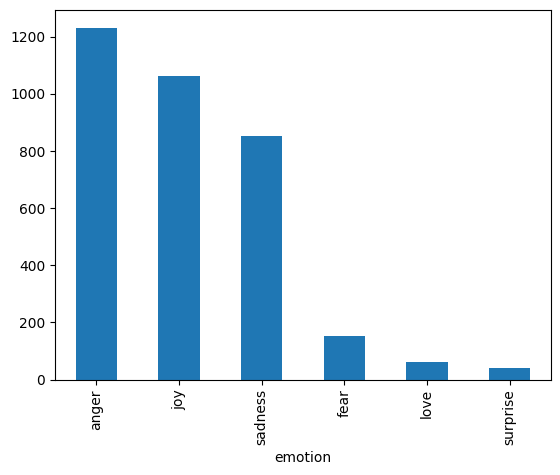

In [ ]:
trustpilot_negative_df = trustpilot_df[trustpilot_df['Review Stars'] < 3]
trustpilot_negative_df['emotion'].value_counts().plot(kind='bar')

In [ ]:
#extract reviews where anger is top emotion
google_anger_df = google_negative_df[google_negative_df['emotion'] == 'anger']
trustpilot_anger_df = trustpilot_negative_df[trustpilot_negative_df['emotion'] == 'anger']

print("Count of Google Reviews with Anger Emotion",len(google_anger_df))
print("Count of Trustpilot Reviews witht Anger Emotion",len(trustpilot_anger_df))

Count of Google Reviews with Anger Emotion 781
Count of Trustpilot Reviews witht Anger Emotion 1232


In [ ]:
combined_anger_reviews = google_anger_df['Comment'].tolist() + trustpilot_anger_df['Review Content'].tolist()
topic_model_anger_reviews = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics_anger_reviews, probs_anger_reviews = topic_model_anger_reviews.fit_transform(combined_anger_reviews)

2026-01-19 08:42:45,775 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:24<00:00,  2.54it/s]
2026-01-19 08:43:14,705 - BERTopic - Embedding - Completed ✓
2026-01-19 08:43:14,706 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-19 08:43:23,785 - BERTopic - Dimensionality - Completed ✓
2026-01-19 08:43:23,787 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-19 08:43:24,144 - BERTopic - Cluster - Completed ✓
2026-01-19 08:43:24,149 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-19 08:43:24,267 - BERTopic - Representation - Completed ✓


In [ ]:
#list out top topics along with their document frequencies
topic_model_anger_reviews.get_topic_info()

Topic  Count                                       Name  \
0      -1    842                 -1_gym_people_machines_one   
1       0     84                0_rude_staff_manager_member   
2       1     58            1_cancel_membership_joining_pay   
3       2     57                2_joining_fee_discount_code   
4       3     55             3_toilets_toilet_changing_room   
5       4     54                    4_parking_car_park_fine   
6       5     51                5_classes_class_booked_book   
7       6     50                 6_music_loud_classes_noise   
8       7     45             7_rude_staff_manager_unhelpful   
9       8     40          8_smell_smelly_ventilation_stinks   
10      9     39            9_closed_open_opening_christmas   
11     10     35            10_cold_showers_shower_freezing   
12     11     34            11_busy_equipment_small_crowded   
13     12     33                    12_pin_code_access_work   
14     13     31              13_air_conditioning_ac_aircon   
15     14     30            14_cold_showers_shower_freezing   
16     15     28              15_water_machine_working_last   
17     16     26  16_cancel_membership_cancellation_charged   
18     17     25                     17_gym_good_get_around   
19     18     23                        18_pin_log_app_sent   
20     19     22                    19_worst_ive_edith_ever   
21     20     21    20_crowded_walked_everything_chelmsford   
22     21     20                      21_pass_day_didnt_pin   
23     22     19              22_equipment_gym_people_staff   
24     23     19                     23_pass_day_code_didnt   
25     24     19           24_showers_sort_order_disgusting   
26     25     18             25_cleaning_stations_sweat_gym   
27     26     17              26_customer_admin_fee_service   
28     27     16          27_phones_people_sitting_machines   
29     28     15               28_crowded_many_machine_wait   
30     29     15                29_lockers_stole_stuff_lock   
31     30     15             30_app_phone_website_messenger   
32     31     15         31_shower_cold_showers_temperature   
33     32     14              32_cleaning_towels_towel_wipe   
34     33     14         33_dirty_toilets_cleanliness_paper   
35     34     13           34_contact_sign_services_payment   
36     35     13               35_kids_standing_around_full   
37     36     12                 36_small_equipment_lot_fit   
38     37     12                  37_water_showers_warm_hot   
39     38     12             38_contact_email_response_days   
40     39     11         39_weights_everywhere_kg_incorrect   
41     40     11             40_wifi_internet_works_someone   
42     41     10             41_benches_bench_unsuitable_ft   
43     42     10             42_rubbish_wipe_equipment_dare   
44     43     10            43_suspended_money_circus_email   

                                       Representation  \
0   [gym, people, machines, one, equipment, time, ...   
1   [rude, staff, manager, member, gym, personal, ...   
2   [cancel, membership, joining, pay, month, gyms...   
3   [joining, fee, discount, code, charged, join, ...   
4   [toilets, toilet, changing, room, rooms, clean...   
5   [parking, car, park, fine, carpark, disabled, ...   
6   [classes, class, booked, book, instructors, ca...   
7   [music, loud, classes, noise, hear, headphones...   
8   [rude, staff, manager, unhelpful, unprofession...   
9   [smell, smelly, ventilation, stinks, air, smel...   
10  [closed, open, opening, christmas, hours, pm, ...   
11  [cold, showers, shower, freezing, temperature,...   
12  [busy, equipment, small, crowded, little, old,...   
13  [pin, code, access, work, wouldnt, enter, gym,...   
14  [air, conditioning, ac, aircon, working, boili...   
15  [cold, showers, shower, freezing, water, boile...   
16  [water, machine, working, last, order, always,...   
17  [cancel, membership, cancellation, charged, ca...   
18  [gym, good, get, a

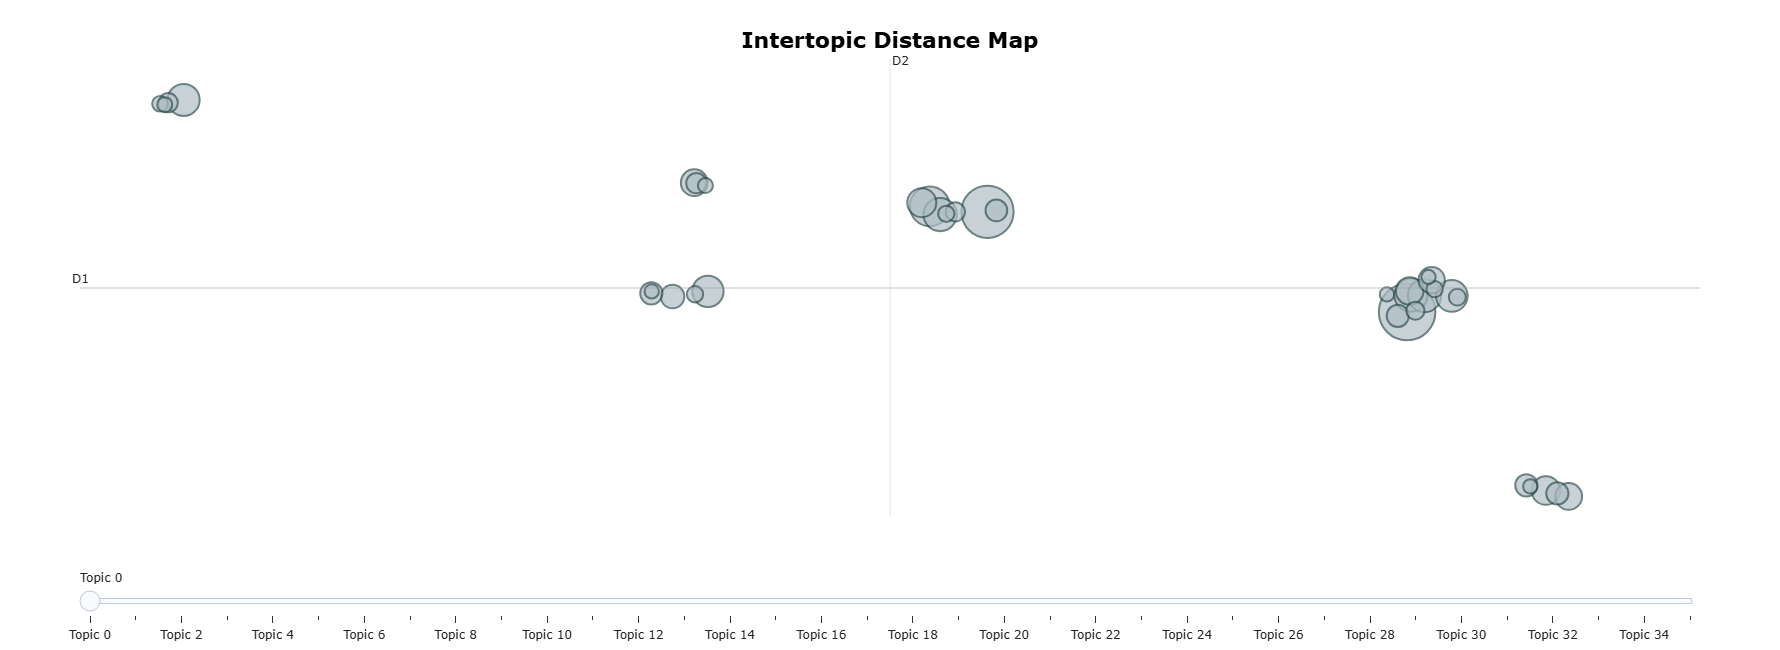

In [ ]:
#show interactive visualisation to topics to identify cluster of topics and to understand intertopic distance map
topic_model_anger_reviews.visualize_topics()

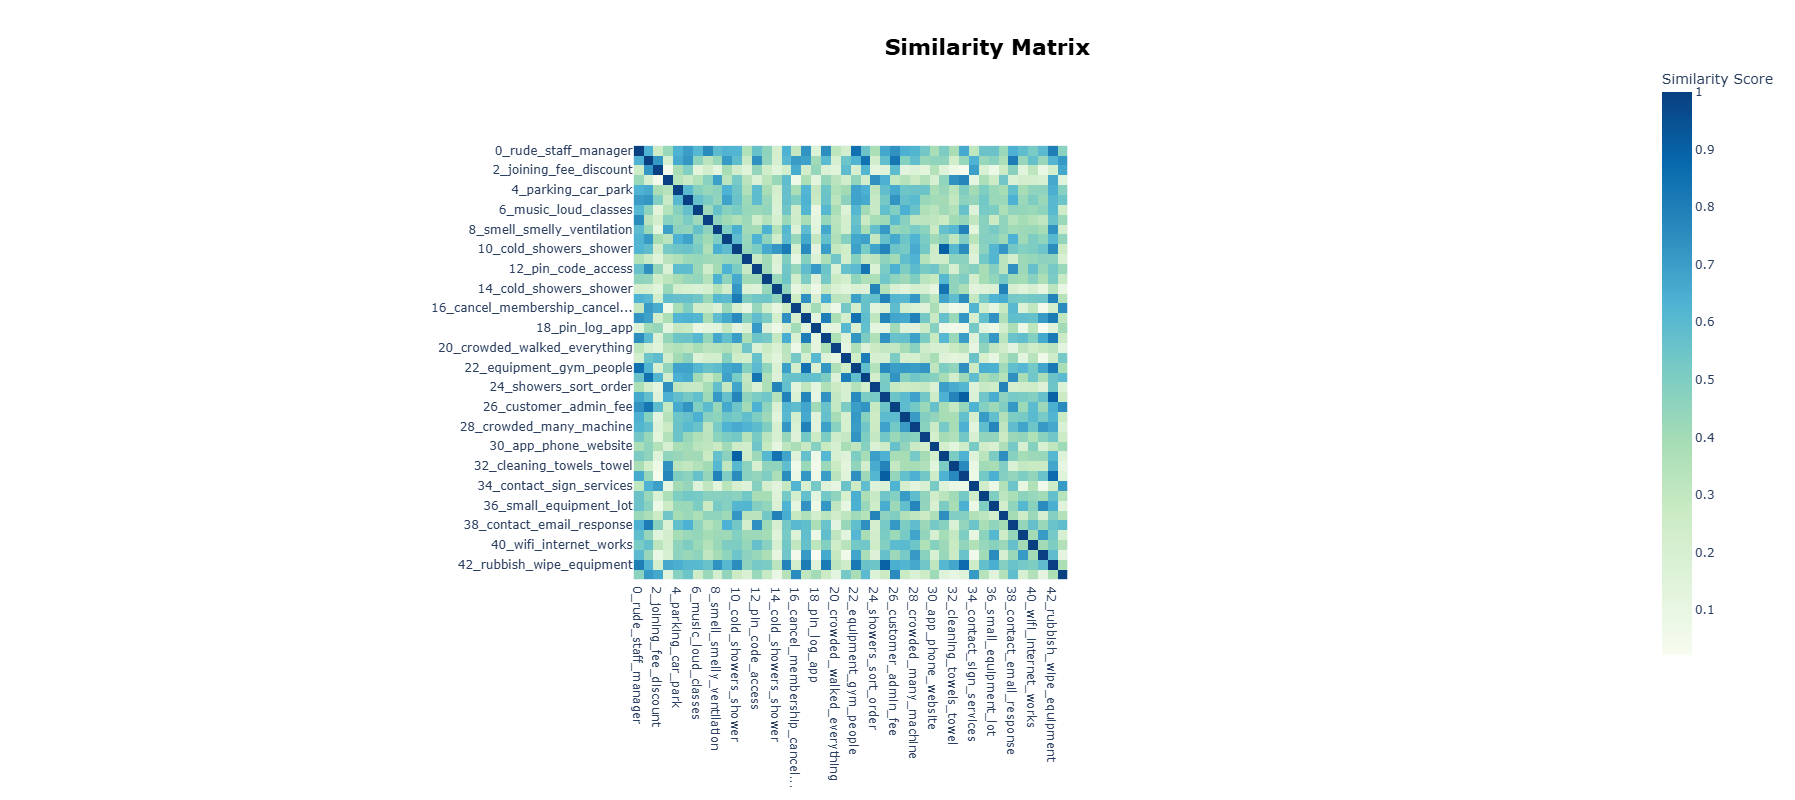

In [ ]:
#plot heatmap showcasing similiarity matrix for 10 clusters
topic_model_anger_reviews.visualize_heatmap()

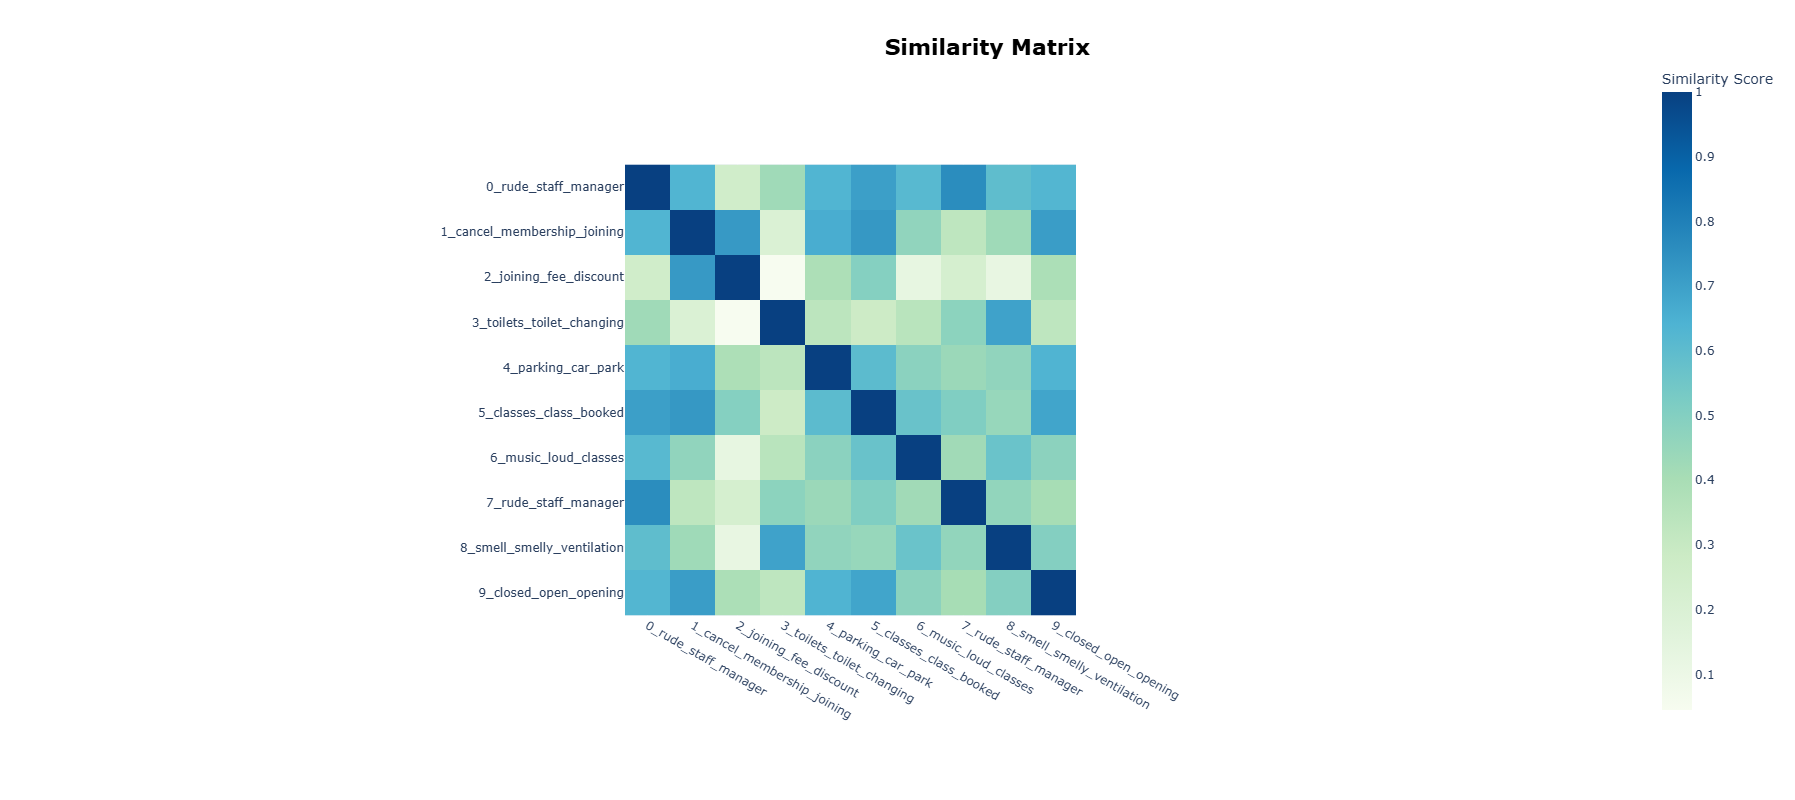

In [ ]:
topic_freq_anger_reviews = topic_model_anger_reviews.get_topic_freq()

top_10_topics_anger_reviews = (
    topic_freq_anger_reviews[topic_freq_anger_reviews.Topic != -1]  # exclude outliers
    .head(10)['Topic']
    .tolist()
)
topic_model_anger_reviews.visualize_heatmap(topics=top_10_topics_anger_reviews)

##
**Emotion Analysis – Key Conclusion**

The emotion analysis using the Bhadresh Savani model demonstrates clearer and more coherent clustering compared to previous runs, indicating improved differentiation of emotionally driven themes. The consistency observed across clusters confirms that anger-related reviews are linked to recurring and identifiable issues rather than isolated incidents. This enables the isolation of primary drivers of dissatisfaction, supporting targeted operational improvements, focused staff training, and informed policy or pricing interventions.

# Using a Large Language Model from Hugging Face

In [ ]:
import requests
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

In [ ]:
OLLAMA_URL = "http://localhost:11434/api/generate"

def run_phi4(prompt, retries=3, timeout=120):
    for attempt in range(retries):
        try:
            response = requests.post(
                OLLAMA_URL,
                json={
                    "model": "phi4-mini",
                    "prompt": prompt,
                    "stream": False
                },
                timeout=timeout
            )
            response.raise_for_status()
            return response.json()["response"]
        except Exception:
            if attempt == retries - 1:
                return ""
            time.sleep(1)

def build_phi4_prompt(review_text):
    return f"""
In the following customer review, pick out the main 3 topics.
Return them in a numbered list format, with each one on a new line.

Customer Review:
\"\"\"{review_text}\"\"\"

Answer:
"""

def build_phi4_suggestion_prompt(review_text):
    return  f"""
For the following text topics obtained from negative customer reviews, can you give some actionable insights that would help this gym company?
Text Topics:
\"\"\"{review_text}\"\"\"

Insights:
"""

def extract_topics(text):
    lines = text.splitlines()
    topics = [
        line.split('.', 1)[1].strip()
        for line in lines
        if line.strip().startswith(('1.', '2.', '3.'))
    ]
    topics += ["", "", ""]
    return topics[:3]

def process_review_phi4(review_text):
    prompt = build_phi4_prompt(review_text)
    output = run_phi4(prompt)
    return extract_topics(output)

def process_topics_phi4(review_text):
    prompt = build_phi4_suggestion_prompt(review_text)
    output = run_phi4(prompt)
    return extract_topics(output)


In [ ]:
def get_topics_parallel_phi4(df, text_col, max_workers=4):
    reviews = df[text_col].fillna("").astype(str).tolist()
    results = [None] * len(reviews)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(process_review_phi4, review): idx
            for idx, review in enumerate(reviews)
        }

        for future in tqdm(as_completed(futures), total=len(futures)):
            idx = futures[future]
            results[idx] = future.result()

    df[['topic_1', 'topic_2', 'topic_3']] = pd.DataFrame(results, index=df.index)
    return df


In [ ]:
def get_suggestions_parallel_phi4(df, text_col, max_workers=4):
    reviews = df[text_col].fillna("").astype(str).tolist()
    results = [None] * len(reviews)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(process_topics_phi4, review): idx
            for idx, review in enumerate(reviews)
        }

        for future in tqdm(as_completed(futures), total=len(futures)):
            idx = futures[future]
            results[idx] = future.result()

    df[['suggestion_1', 'suggestion_2', 'suggestion_3']] = pd.DataFrame(results, index=df.index)
    return df

In [ ]:
print("Count of negative google reviews: ", len(google_negative_df))
print("Count of negative trustpilot reviews: ", len(trustpilot_negative_df))

Count of negative google reviews:  2423
Count of negative trustpilot reviews:  3403


In [ ]:
google_LLM_df = get_topics_parallel_phi4(
    google_negative_df.head(200),
    text_col='Comment',
    max_workers=4
)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [40:34<00:00, 12.17s/it]


In [ ]:
trustpilot_LLM_df = get_topics_parallel_phi4(
    trustpilot_negative_df.head(200),
    text_col='Review Content',
    max_workers=4
)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [32:33<00:00,  9.77s/it]


In [ ]:
google_LLM_df.head()

SurveyID for external use (e.g. tech support)             Location Name  \
1                       e9b62vyxtkwrrrfyzc5hz6rk    cambridge leisure park   
4                       edkrxvyxtkwrrrfyzc5hz6rk        bristol union gate   
7                       erx6f88stkwrrrfyzc5hz6rk                new barnet   
19                      em5fxz3stkwrrrfyzc5hz6rk  manchester cheetham hill   
29                      etbwctzttkwrrrfyzc5hz6rk    newcastle eldon garden   

   Social Media Source       Creation Date  \
1       Google Reviews 2024-05-09 22:48:39   
4       Google Reviews 2024-05-09 21:48:00   
7       Google Reviews 2024-05-09 20:16:04   
19      Google Reviews 2024-05-09 17:03:50   
29      Google Reviews 2024-05-09 08:38:07   

                                              Comment  Overall Score  \
1   many students two local colleges go leave rubb...              1   
4   current member gym quite dirty often theres so...              1   
7   gym way hot even workout windows open ac barel...              2   
19  access wc empty assistance gain access fault f...              2   
29  gym year im finally leaving im gutted staff pt...              2   

    is_english  source  emotion                  topic_1  \
1         True  Google    anger          Gym Cleanliness   
4         True  Google  sadness          Gym cleanliness   
7         True  Google    anger           Gym facilities   
19        True  Google  sadness         Return WC (W.C.)   
29        True  Google     love  Overcrowding at the Gym   

                          topic_2  \
1     Student Behavior in the Gym   
4         Overcrowding at the gym   
7    HVAC system (windows and AC)   
19                     Assistance   
29  Poor Equipment and Facilities   

                                              topic_3  
1   Management Response to Issues (CEO's involveme...  
4                Poor air circulation in the gym area  
7                   Staff behavior/quality of service  
19                 Fault / Issues with Access/Careers  
29                           Lack of Customer Service

In [ ]:
trustpilot_LLM_df.head()

Review ID Review Created (UTC)  \
2   663d375859621080d08e6198  2024-05-09 22:51:00   
19  663cf54657cc0d5b9e4c3cf6  2024-05-09 18:09:00   
35  663cb2bb3dd3bfa5d9aa722d  2024-05-09 13:25:00   
36  663cb0d7d2ae954c99ee3bb1  2024-05-09 13:17:00   
38  663ca6eef65e849c2d5d78d9  2024-05-09 12:35:00   

                              Review Title  \
2                           Extremely busy   
19      The men’s changing rooms smell bad   
35  All I wanted to do was set up another…   
36  What ever you do don’t downgrade your…   
38                              Awful Gyms   

                                       Review Content  Review Stars  \
2                            extremely busy fresh air             1   
19  mens changing rooms smell bad need deep clean ...             2   
35  wanted set another debit card direct debit opt...             1   
36  ever dont downgrade membership core plus cance...             1   
38  poor parking enough kit unhelpful trainers sta...             2   

   Source Of Review Review Language              Domain URL Webshop Name  \
2             AFSv2              en  http://www.puregym.com   PureGym UK   
19            AFSv2              en  http://www.puregym.com   PureGym UK   
35            AFSv2              en  http://www.puregym.com   PureGym UK   
36            AFSv2              en  http://www.puregym.com   PureGym UK   
38            AFSv2              en  http://www.puregym.com   PureGym UK   

            Business Unit ID Company Reply Date (UTC)  \
2   508df4ea00006400051dd7b1                      NaT   
19  508df4ea00006400051dd7b1                      NaT   
35  508df4ea00006400051dd7b1                      NaT   
36  508df4ea00006400051dd7b1                      NaT   
38  508df4ea00006400051dd7b1                      NaT   

              Location Name                           Location ID  is_english  \
2       sutton times square  0b78c808-f671-482b-8687-83468b7b5bc1        True   
19  leeds city centre south  2b4be59b-f0c3-4b19-a7e3-1ef2ce3719a9        True   
35                      nan                                   NaN        True   
36                      nan                                   NaN        True   
38                      nan                                   NaN        True   

        source  emotion                                       topic_1  \
2   Trustpilot      joy  Busy schedule or time constraints for travel   
19  Trustpilot      joy                              Smell Management   
35  Trustpilot      joy                            Debit Card Options   
36  Trustpilot  sadness                    Membership Downgrade Issue   
38  Trustpilot  sadness                       Poor Parking Experience   

                                       topic_2  \
2     Preference for scenic routes (fresh air)   
19  Regular Cleaning of Toilets and Facilities   
35                         Direct Debit Option   
36                      Payment Refund Request   
38                  Unhelpful Kit and Trainers   

                                              topic_3  
2    Desire to avoid crowded places during peak times  
19             Customer Satisfaction and Expectations  
35                  Joining Fee for Rejoining Service  
36  Confirmation of Charges and Service Dissatisfa...  
38  Inadequate Staff Assistance and Proper Storage...

In [ ]:
from collections import Counter

def get_topic_counter(df):
    topics = (
        df[['topic_1', 'topic_2', 'topic_3']]
        .values
        .ravel()
        .tolist()
    )

    topics = [
        t.strip().lower()
        for t in topics
        if isinstance(t, str) and t.strip()
    ]

    return Counter(topics)

google_topics = get_topic_counter(google_LLM_df)
trustpilot_topics = get_topic_counter(trustpilot_LLM_df)

combined_topics = google_topics + trustpilot_topics
top_3_combined_topics = combined_topics.most_common(3)
top_3_combined_topics


[('customer dissatisfaction', 10),
 ('customer service experience', 5),
 ('gym facilities', 4)]

In [ ]:
combined_df = pd.DataFrame({
    'topic': list(combined_topics.keys()),
    'total_count': list(combined_topics.values()),
    'google_count': [google_topics[t] for t in combined_topics],
    'trustpilot_count': [trustpilot_topics[t] for t in combined_topics]
}).sort_values('total_count', ascending=False)

combined_df.head()

topic  total_count  google_count  trustpilot_count
477     customer dissatisfaction           10             3                 7
284  customer service experience            5             1                 4
76       customer service issues            4             3                 1
377        gym equipment quality            4             2                 2
46                staff behavior            4             3                 1

In [ ]:
#run BERTopic for all_topicstop_3
bert_model_top_topics_from_LLM = BERTopic(language="english", calculate_probabilities=True, verbose=True)
bert_model_all_topics_from_LLM, bert_model_probs_all_topics_from_LLM = bert_model_top_topics_from_LLM.fit_transform(combined_df['topic'].tolist())

2026-01-19 10:15:59,895 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|█████████████████████████████████████████████████████████████████████████| 36/36 [00:03<00:00, 10.76it/s]
2026-01-19 10:16:07,531 - BERTopic - Embedding - Completed ✓
2026-01-19 10:16:07,532 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-19 10:16:10,697 - BERTopic - Dimensionality - Completed ✓
2026-01-19 10:16:10,699 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-19 10:16:10,869 - BERTopic - Cluster - Completed ✓
2026-01-19 10:16:10,874 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-19 10:16:10,938 - BERTopic - Representation - Completed ✓


In [ ]:
#list out top topics along with their document frequencies
bert_model_top_topics_from_LLM.get_topic_info()

Topic  Count                                           Name  \
0      -1    279                            -1_and_of_or_issues   
1       0     95           0_cleanliness_hygiene_dirty_cleaning   
2       1     86                    1_gym_equipment_weight_gyms   
3       2     53              2_service_customer_poor_customers   
4       3     53                 3_gym_experience_services_pure   
5       4     51    4_equipment_availability_facilities_quality   
6       5     41           5_staff_responsiveness_behavior_rude   
7       6     35     6_experience_overall_satisfaction_customer   
8       7     32                 7_return_refund_policy_process   
9       8     30         8_product_quality_performance_features   
10      9     29          9_email_delivery_confirmation_package   
11     10     29    10_dissatisfaction_customer_frustration_due   
12     11     28          11_assistance_contact_contacting_team   
13     12     27         12_membership_upgrade_upgrading_status   
14     13     26            13_technical_access_issues_entrance   
15     14     26               14_payment_debit_problems_direct   
16     15     23            15_cleanliness_gym_hygiene_stations   
17     16     18         16_environment_gym_ambiance_atmosphere   
18     17     18                 17_joining_fee_fees_membership   
19     18     18              18_registration_signup_up_signing   
20     19     17                    19_parking_park_car_drivers   
21     20     17         20_cancellation_policy_classes_process   
22     21     15        21_air_conditioning_temperature_control   
23     22     15       22_overcrowding_crowded_overcrowded_rush   
24     23     14  23_pricing_transparency_compared_expectations   
25     24     13                       24_locker_room_punch_bag   
26     25     13              25_pin_number_issue_functionality   
27     26     13                     26_pass_day_purchase_issue   
28     27     11             27_safety_concerns_injury_personal   
29     28     10    28_teenagers_behavior_student_inappropriate   

                                       Representation  \
0   [and, of, or, issues, communication, accessibi...   
1   [cleanliness, hygiene, dirty, cleaning, shower...   
2   [gym, equipment, weight, gyms, weights, size, ...   
3   [service, customer, poor, customers, response,...   
4   [gym, experience, services, pure, at, membersh...   
5   [equipment, availability, facilities, quality,...   
6   [staff, responsiveness, behavior, rude, attitu...   
7   [experience, overall, satisfaction, customer, ...   
8   [return, refund, policy, process, delayed, wc,...   
9   [product, quality, performance, features, effe...   
10  [email, delivery, confirmation, package, time,...   
11  [dissatisfaction, customer, frustration, due, ...   
12  [assistance, contact, contacting, team, suppor...   
13  [membership, upgrade, upgrading, status, pureg...   
14  [technical, access, issues, entrance, entry, e...   
15  [payment, debit, problems, direct, bank, card,...   
16  [cleanliness, gym, hygiene, stations, at, main...   
17  [environment, gym, ambiance, atmosphere, tempe...   
18  [joining, fee, fees, membership, pricing, cost...   
19  [registration, signup, up, signing, process, a...   
20  [parking, park, car, drivers, cars, euro, outs...   
21  [cancellation, policy, classes, process, cance...   
22  [air, conditioning, temperature, control, fres...   
23  [overcrowding, crowded, overcrowded, rush, spa...   
24  [pricing, transparency, compared, expectations...   
25  [locker, room, punch, bag, lockers, security, ...   
26  [pin, number, issue, functionality, delivery, ...   
27  [pass, day, purchase, issue, accidental, instr...   
28  [safety, concerns, injury, personal, evacuatio...   
29  [teenagers, behavior, student, inappropriate, ...   

                                  Representative_Docs  
0   [poor quality and maintenance of the fitness f...  
1   [poor cleanliness and maintenance of men's

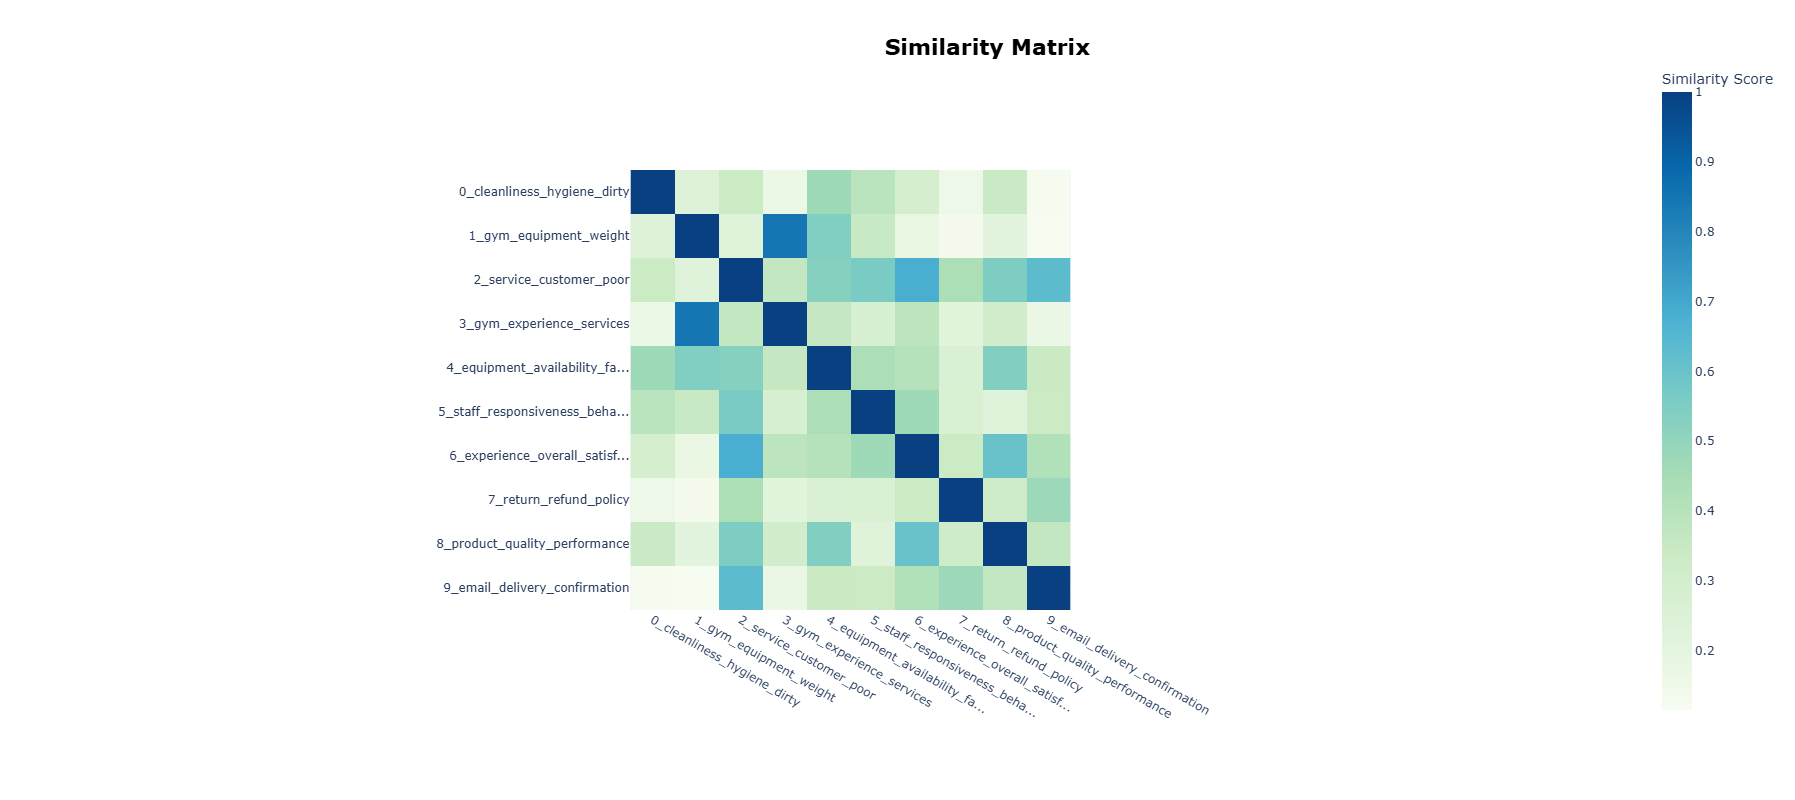

In [ ]:
topic_from_LLM_freq = bert_model_top_topics_from_LLM.get_topic_freq()

top_10_topics_from_LLM_freq = (
    topic_from_LLM_freq[topic_from_LLM_freq.Topic != -1]  # exclude outliers
    .head(10)['Topic']
    .tolist()
)
bert_model_top_topics_from_LLM.visualize_heatmap(topics=top_10_topics_from_LLM_freq)

In [ ]:
print("Count of combined top topics from LLM:", len(combined_df))

Count of combined top topics from LLM: 1135


###Insights:

**LLM-Based Topic Extraction – Key Conclusion**

The application of LLM-based topic extraction using the Phi-4-mini model via Ollama further enhanced the clarity and interpretability of the findings. Even when applied to a limited sample of 200 negative reviews from each dataset, the model moved beyond broad dissatisfaction themes to surface more specific operational and experiential pain points. These topics provide a clearer, business-relevant understanding of the underlying issues driving negative customer feedback and demonstrate the value of LLMs in complementing traditional topic modelling approaches.

In [ ]:
suggestions_df = get_suggestions_parallel_phi4(
    combined_df.head(150),
    text_col='topic',
    max_workers=4
)

100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [3:40:17<00:00, 88.11s/it]


In [ ]:
suggestions_df.sort_values(by='total_count', ascending=False)

topic  total_count  \
477                          customer dissatisfaction           10   
284                       customer service experience            5   
76                            customer service issues            4   
377                             gym equipment quality            4   
46                                     staff behavior            4   
..                                                ...          ...   
129                              busy gym environment            1   
130           dirty changing rooms and unclean spaces            1   
131                 frequent closures due to flooding            1   
132         dirty and poorly maintained gym equipment            1   
133  lack of sanitization products (sanitizer sprays)            1   

     google_count  trustpilot_count  \
477             3                 7   
284             1                 4   
76              3                 1   
377             2                 2   
46              3                 1   
..            ...               ...   
129             1                 0   
130             1                 0   
131             1                 0   
132             1                 0   
133             1                 0   

                                          suggestion_1  \
477                      **Improve Customer Service**:   
284                                                      
76                                                       
377                                                      
46   **Training and Development**: Conduct regular ...   
..                                                 ...   
129                                                      
130                                                      
131                                                      
132                                                      
133  **Increase Availability**: Ensure there is an ...   

                                          suggestion_2  \
477  **Enhance Facility Cleanliness and Maintenance**:   
284                                                      
76                                                       
377                                                      
46   **Positive Reinforcement Programs**: Implement...   
..                                                 ...   
129                                                      
130                                                      
131                                                      
132                                                      
133  **Visible Placement:** Place sanitization stat...   

                                          suggestion_3  
477             **Staff Scheduling and Availability:**  
284                                                     
76                                                      
377                                                     
46   **Feedback Mechanism Improvement:** Establish ...  
..                                                 ...  
129                                                     
130                                                     
131                                                     
132                                                     
133  **Promote Usage**: Create awareness campaigns ...  

[150 rows x 7 columns]

In [ ]:
from collections import Counter

def get_suggestions_counter(df):
    suggestions = (
        df[['suggestion_1', 'suggestion_2', 'suggestion_3']]
        .values
        .ravel()
        .tolist()
    )

    suggestion = [
        s.strip().lower()
        for s in suggestions
        if isinstance(s, str) and s.strip()
    ]

    return Counter(suggestion)

get_all_suggestions_counter = get_suggestions_counter(suggestions_df)
top_3_suggestions = get_all_suggestions_counter.most_common(10)
top_3_suggestions

[('**improve customer service**:', 1),
 ('**enhance facility cleanliness and maintenance**:', 1),
 ('**staff scheduling and availability:**', 1),
 ('**training and development**: conduct regular training sessions focused specifically on interpersonal skills such as empathy, patience, active listening, conflict resolution techniques for the employees interacting with customers.',
  1),
 ('**positive reinforcement programs**: implement a recognition program that rewards excellent customer service among gym staff members based upon positive feedback or peer reviews to motivate them towards better behavior and professionalism continuously.',
  1),
 ('**feedback mechanism improvement:** establish an easy-to-use platform where both trainers and clients can share their experiences with one another, enabling immediate acknowledgment of issues as well as quick resolution through direct communication channels like mobile apps that facilitate instant reporting/correction processes for staff invol

##
**Translating Insights into Actionable Recommendations**

The identified topics were further analysed using an LLM-based prompt to generate practical, implementation-ready suggestions for improvement. By producing three targeted recommendations per topic and collating them across reviews, this approach surfaces recurring, high-impact actions that can be prioritised by organisation to address operational gaps, service issues, and customer experience challenges.

# Using Gensim

In [ ]:
!pip install gensim

In [ ]:
!pip install pyLDAvis

In [ ]:
#Preprocess data for LDA model from Gensim
import gensim
from gensim.utils import simple_preprocess
import pyLDAvis.gensim_models # Import pyLDAvis
from gensim import corpora

#combine negative reviews from both datasets
negative_reviews = pd.concat([google_negative_df['Comment'], trustpilot_negative_df['Review Content']])

#preprocess negative_reviews
processed_docs = [simple_preprocess(doc) for doc in negative_reviews]

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

#tokenise data, specify number of topics=10
lda_model = gensim.models.LdaMulticore(corpus, num_topics=10, id2word=dictionary, passes=15, workers=4)

#evaluate the model
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.024*"gym" + 0.018*"air" + 0.012*"equipment" + 0.012*"hot" + 0.008*"work" + 0.007*"water" + 0.007*"good" + 0.007*"dont" + 0.007*"conditioning" + 0.006*"really"
Topic: 1 
Words: 0.033*"gym" + 0.018*"get" + 0.017*"membership" + 0.016*"day" + 0.015*"email" + 0.013*"pin" + 0.013*"pass" + 0.013*"app" + 0.012*"code" + 0.010*"access"
Topic: 2 
Words: 0.025*"gym" + 0.016*"fee" + 0.014*"membership" + 0.013*"joining" + 0.007*"time" + 0.006*"equipment" + 0.006*"would" + 0.006*"pay" + 0.005*"cant" + 0.005*"month"
Topic: 3 
Words: 0.033*"gym" + 0.013*"one" + 0.011*"machines" + 0.010*"equipment" + 0.007*"machine" + 0.007*"puregym" + 0.006*"broken" + 0.006*"staff" + 0.005*"manager" + 0.005*"also"
Topic: 4 
Words: 0.026*"gym" + 0.019*"showers" + 0.017*"water" + 0.010*"cold" + 0.009*"shower" + 0.009*"time" + 0.009*"changing" + 0.009*"get" + 0.008*"staff" + 0.007*"dont"
Topic: 5 
Words: 0.030*"gym" + 0.013*"staff" + 0.009*"one" + 0.008*"membership" + 0.007*"manager" + 0.007*"customer" 

In [ ]:
#show visualisations of topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.080277  0.015046       1        1  15.036333
6     -0.058803 -0.023561       2        1  14.659262
9      0.026142 -0.026785       3        1  14.031492
1      0.227220  0.037878       4        1  12.124526
5      0.070258  0.004582       5        1   9.196815
4     -0.063277  0.089784       6        1   8.240948
0     -0.058296  0.034995       7        1   7.821543
8     -0.046303 -0.096812       8        1   7.630385
2      0.047948 -0.066072       9        1   6.036322
3     -0.064612  0.030944      10        1   5.222373, topic_info=         Term        Freq        Total Category  logprob  loglift
235   classes  453.000000   453.000000  Default  30.0000  30.0000
1128    class  396.000000   396.000000  Default  29.0000  29.0000
720   showers  465.000000   465.000000  Default  28.0000  28.0000
246       air  404.000000   404.000000  Default  27.0000  27.0000
428     water  432.000000   432.000000  Default  26.0000  26.0000
...       ...         ...          ...      ...      ...      ...
70       work   31.948024   670.259712  Topic10  -5.6875  -0.0913
31      years   25.809161   308.653390  Topic10  -5.9008   0.4707
23     people   28.957976  1050.698472  Topic10  -5.7857  -0.6391
40       good   26.325149   645.271094  Topic10  -5.8810  -0.2469
10         go   25.766756   690.595256  Topic10  -5.9025  -0.3363

[834 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
4450       8  0.923548      ab
5389       5  0.885725  abroad
52         1  0.057559      ac
52         2  0.149654      ac
52         3  0.011512      ac
...      ...       ...     ...
1673       8  0.713364    yoga
1673       9  0.079263    yoga
11332     10  0.763506   zenga
2225       8  0.787429   zumba
2225       9  0.168735   zumba

[2848 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 10, 2, 6, 5, 1, 9, 3, 4])

##
**LDA Topic Modelling – Validation and Comparison**

In the final stage of the analysis, Latent Dirichlet Allocation (LDA) was applied using Gensim to provide a comparative benchmark against earlier topic modelling approaches. The resulting topic visualisations were used to assess consistency in dominant themes and to evaluate whether any additional insights emerged. Overall, the LDA results reinforced the key themes identified through BERTopic and LLM-based extraction, supporting the robustness of the findings while confirming that more advanced methods offered clearer and more actionable topic separation.